In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/

import pickle
from tqdm import tqdm
import os


from collections import Counter

In [2]:
from sklearn.model_selection import RandomizedSearchCV

In [3]:
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
import time
from sklearn.metrics import roc_auc_score,make_scorer,accuracy_score

In [4]:
from scipy.sparse import hstack

In [5]:
from sklearn.metrics import roc_curve, auc


In [6]:
data  = pd.read_csv('preprocessed_data.csv', nrows=50000)
# data  = pd.read_csv('preprocessed_data.csv', nrows=50000) # you can take less number of rows like this
data.head(5)

,school_state,teacher_prefix,project_grade_category,teacher_number_of_previously_posted_projects,project_is_approved,clean_categories,clean_subcategories,essay,price
0,ca,mrs,grades_prek_2,53,1,math_science,appliedsciences health_lifescience,i fortunate enough use fairy tale stem kits cl...,725.05
1,ut,ms,grades_3_5,4,1,specialneeds,specialneeds,imagine 8 9 years old you third grade classroo...,213.03
2,ca,mrs,grades_prek_2,10,1,literacy_language,literacy,having class 24 students comes diverse learner...,329.00
3,ga,mrs,grades_prek_2,2,1,appliedlearning,earlydevelopment,i recently read article giving students choice...,481.04
4,wa,mrs,grades_3_5,2,1,literacy_language,literacy,my students crave challenge eat obstacles brea...,17.74


In [7]:
data['project_is_approved'].value_counts()

1    41993
0     8007
Name: project_is_approved, dtype: int64

In [8]:
y = data['project_is_approved'].values
X = data.drop(['project_is_approved'], axis=1)

In [9]:
# train test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, stratify=y)

In [10]:
X_train.shape

(33500, 8)

# Vectorizer function: Converting words to bag of words(BOW)

In [11]:
class word_converter():
    def __init__(self,data_frame,feature_name):
        self.data_fr = data_frame
        self.feature_convert = feature_name
        self.min_df = 10
        self.n_gram_range = (1,4)
        self.max_features = 10000
    
    def fit_data_bow(self):
        #self.vectorizer = CountVectorizer(min_df=self.min_df,ngram_range=self.n_gram_range,max_features=self.max_features)
        self.vectorizer = CountVectorizer(min_df=self.min_df,ngram_range=self.n_gram_range,max_features=self.max_features)
        self.vectorizer.fit(self.data_fr[self.feature_convert].values)        

    def fit_data_tfidf(self):
        self.n_gram_range = (1,4)
        self.vectorizer = TfidfVectorizer(min_df=self.min_df,ngram_range=self.n_gram_range,max_features=self.max_features)
        self.vectorizer.fit(self.data_fr[self.feature_convert].values)        
        
    def to_vectorized(self,text_values):
        return self.vectorizer.transform(text_values)

    def get_fitted_feature_names(self):
        return self.vectorizer.get_feature_names()
    

In [12]:
# List for capturing features
feature_importance_list=[]

### Vector encoding for school location(state)

In [13]:
school_obj = word_converter(X_train,'school_state')
school_obj.fit_data_bow()
state_feature_names = school_obj.get_fitted_feature_names()

x_train_state_ohe = school_obj.to_vectorized(X_train['school_state'].values)
#x_cv_state_ohe = school_obj.to_vectorized(X_cv['school_state'].values)
x_test_state_ohe = school_obj.to_vectorized(X_test['school_state'].values)

In [14]:
feature_importance_list.extend(state_feature_names)

### Vector encoding for teacher prefix

In [15]:
teacher_prefix_obj = word_converter(X_train,'teacher_prefix')
teacher_prefix_obj.fit_data_bow()
teacher_prefix_feature_names = teacher_prefix_obj.get_fitted_feature_names()

x_train_teacher_prefix_ohe = teacher_prefix_obj.to_vectorized(X_train['teacher_prefix'].values)
#x_cv_teacher_prefix_ohe = teacher_prefix_obj.to_vectorized(X_cv['teacher_prefix'].values)
x_test_teacher_prefix_ohe = teacher_prefix_obj.to_vectorized(X_test['teacher_prefix'].values)

In [16]:
feature_importance_list.extend(teacher_prefix_feature_names)
#len(feature_importance_list)

### Vector encoding for grades

In [17]:
grade_category_obj = word_converter(X_train,'project_grade_category')
grade_category_obj.fit_data_bow()
grade_category_feature_names = grade_category_obj.get_fitted_feature_names()

x_train_grade_category_ohe = grade_category_obj.to_vectorized(X_train['project_grade_category'].values)
#x_cv_grade_category_ohe = grade_category_obj.to_vectorized(X_cv['project_grade_category'].values)
x_test_grade_category_ohe = grade_category_obj.to_vectorized(X_test['project_grade_category'].values)

In [18]:
feature_importance_list.extend(grade_category_feature_names)
#len(feature_importance_list)

### Vector encoding for clean_categories

In [19]:
clean_category_obj = word_converter(X_train,'clean_categories')
clean_category_obj.fit_data_bow()
clean_category_feature_names = clean_category_obj.get_fitted_feature_names()

x_train_clean_category_ohe = clean_category_obj.to_vectorized(X_train['clean_categories'].values)
#x_cv_clean_category_ohe = clean_category_obj.to_vectorized(X_cv['clean_categories'].values)
x_test_clean_category_ohe = clean_category_obj.to_vectorized(X_test['clean_categories'].values)

In [20]:
feature_importance_list.extend(clean_category_feature_names)
#len(feature_importance_list)

### Vector encoding for clean_subcategories

In [21]:
clean_sub_category_obj = word_converter(X_train,'clean_subcategories')
clean_sub_category_obj.fit_data_bow()
clean_sub_category_feature_names = clean_sub_category_obj.get_fitted_feature_names()

x_train_clean_sub_category_ohe = clean_sub_category_obj.to_vectorized(X_train['clean_subcategories'].values)
#x_cv_clean_sub_category_ohe = clean_sub_category_obj.to_vectorized(X_cv['clean_subcategories'].values)
x_test_clean_sub_category_ohe = clean_sub_category_obj.to_vectorized(X_test['clean_subcategories'].values)

In [22]:
feature_importance_list.extend(clean_sub_category_feature_names)
#len(feature_importance_list)

### Vector encoding for Essay - BOW

In [23]:
essay_obj = word_converter(X_train,'essay')
essay_obj.fit_data_bow()
essay_bow_feature_names = essay_obj.get_fitted_feature_names()

x_train_essay_bow_ohe = essay_obj.to_vectorized(X_train['essay'].values)
#x_cv_essay_bow_ohe = essay_obj.to_vectorized(X_cv['essay'].values)
x_test_essay_bow_ohe = essay_obj.to_vectorized(X_test['essay'].values)

### Vector encoding for Essay - TFIDF

In [24]:
essay_tfidf_obj = word_converter(X_train,'essay')
essay_tfidf_obj.fit_data_tfidf()
essay_tfidf_feature_names = essay_tfidf_obj.get_fitted_feature_names()

x_train_essay_tfidf_ohe = essay_tfidf_obj.to_vectorized(X_train['essay'].values)
#x_cv_essay_tfidf_ohe = essay_tfidf_obj.to_vectorized(X_cv['essay'].values)
x_test_essay_tfidf_ohe = essay_tfidf_obj.to_vectorized(X_test['essay'].values)

# Numerical features conversion

In [25]:
from sklearn.preprocessing import Normalizer
normalizer = Normalizer()
normalizer.fit(X_train['price'].values.reshape(1,-1))
X_train_price_norm = normalizer.transform(X_train['price'].values.reshape(1,-1))
#X_cv_price_norm = normalizer.transform(X_cv['price'].values.reshape(1,-1))
X_test_price_norm = normalizer.transform(X_test['price'].values.reshape(1,-1))

print("After vectorizations")
print(X_train_price_norm.shape, y_train.shape)
#print(X_cv_price_norm.shape, y_cv.shape)
print(X_test_price_norm.shape, y_test.shape)
print("="*100)

After vectorizations
(1, 33500) (33500,)
(1, 16500) (16500,)


In [26]:
from sklearn.preprocessing import Normalizer
normalizer = Normalizer()
normalizer.fit(X_train['teacher_number_of_previously_posted_projects'].values.reshape(1,-1))
X_train_ttl_projs_tchr = normalizer.transform(X_train['teacher_number_of_previously_posted_projects'].values.reshape(1,-1))
#X_cv_ttl_projs_tchr = normalizer.transform(X_cv['teacher_number_of_previously_posted_projects'].values.reshape(1,-1))
X_test_ttl_projs_tchr = normalizer.transform(X_test['teacher_number_of_previously_posted_projects'].values.reshape(1,-1))

print("After vectorizations")
print(X_train_ttl_projs_tchr.shape, y_train.shape)
#print(X_cv_ttl_projs_tchr.shape, y_cv.shape)
print(X_test_ttl_projs_tchr.shape, y_test.shape)
print("="*100)

After vectorizations
(1, 33500) (33500,)
(1, 16500) (16500,)


# Concatenating all features - Set 1

In [27]:
X_train_set_1 = hstack((x_train_state_ohe,x_train_teacher_prefix_ohe,x_train_grade_category_ohe,x_train_clean_category_ohe,x_train_clean_sub_category_ohe,x_train_essay_bow_ohe)).tocsr()

#X_cv_set_1 = hstack((x_cv_state_ohe,x_cv_teacher_prefix_ohe,x_cv_grade_category_ohe,x_cv_clean_category_ohe,x_cv_clean_sub_category_ohe,x_cv_essay_bow_ohe)).tocsr()

X_test_set_1 = hstack((x_test_state_ohe,x_test_teacher_prefix_ohe,x_test_grade_category_ohe,x_test_clean_category_ohe,x_test_clean_sub_category_ohe,x_test_essay_bow_ohe)).tocsr()

In [28]:
print("Final Data matrix")
print(X_train_set_1.shape, y_train.shape)
#print(X_cv_set_1.shape, y_cv.shape)
print(X_test_set_1.shape, y_test.shape)
print("="*100)

Final Data matrix
(33500, 10275) (33500,)
(16500, 10275) (16500,)


# Concatenating all features - Set 2

In [29]:
X_train_set_2 = hstack((x_train_state_ohe,x_train_teacher_prefix_ohe,x_train_grade_category_ohe,x_train_clean_category_ohe,x_train_clean_sub_category_ohe,x_train_essay_tfidf_ohe)).tocsr()

#X_cv_set_2 = hstack((x_cv_state_ohe,x_cv_teacher_prefix_ohe,x_cv_grade_category_ohe,x_cv_clean_category_ohe,x_cv_clean_sub_category_ohe,x_cv_essay_tfidf_ohe)).tocsr()

X_test_set_2 = hstack((x_test_state_ohe,x_test_teacher_prefix_ohe,x_test_grade_category_ohe,x_test_clean_category_ohe,x_test_clean_sub_category_ohe,x_test_essay_tfidf_ohe)).tocsr()

# y_train, y_cv

In [30]:
print("Final Data matrix")
print(X_train_set_2.shape, y_train.shape)
#print(X_cv_set_2.shape, y_cv.shape)
print(X_test_set_2.shape, y_test.shape)
print("="*100)

Final Data matrix
(33500, 10275) (33500,)
(16500, 10275) (16500,)


In [31]:
from sklearn.naive_bayes import MultinomialNB

In [32]:
def batch_predict(clf, data):
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs
    y_data_pred = []
    tr_loop = data.shape[0] - data.shape[0]%1000
    # consider you X_tr shape is 49041, then your tr_loop will be 49041 - 49041%1000 = 49000
    # in this for loop we will iterate unti the last 1000 multiplier
    for i in range(0, tr_loop, 1000):
        y_data_pred.extend(clf.predict_proba(data[i:i+1000])[:,1])
    # we will be predicting for the last data points
    if data.shape[0]%1000 !=0:
        y_data_pred.extend(clf.predict_proba(data[tr_loop:])[:,1])
    
    return y_data_pred

In [33]:
def plot_hyper_auc(results):
    plt.figure(figsize=(20,10))
    train_auc= results['mean_train_score']
    train_auc_std= results['std_train_score']
    cv_auc = results['mean_test_score'] 
    cv_auc_std= results['std_test_score']
    alpha_params_vals =  results['param_alpha']

    plt.plot(alpha_params_vals, train_auc, label='Train AUC')
    plt.plot(alpha_params_vals, cv_auc, label='CV AUC')

    plt.scatter(alpha_params_vals, train_auc, label='Train AUC points')
    plt.scatter(alpha_params_vals, cv_auc, label='CV AUC points')


    plt.legend()
    plt.xlabel("Alpha: hyperparameter")
    plt.ylabel("AUC")
    plt.title("Hyper parameter Vs AUC plot")
    plt.grid()
    plt.show()

In [34]:
data['project_is_approved'].value_counts()

1    41993
0     8007
Name: project_is_approved, dtype: int64

In [35]:
# intial_alpha=0.00001
# alpha_list_values=[0.00001,0.0005, 0.0001,0.005,0.001,0.05,0.01,0.1,0.5,1,5,10,50,100]
# scoring=make_scorer(roc_auc_score)

    
# print(alpha_list_values)

## Note: In this assignment it was mentioned to use alpha values b/w :
[0.00001,0.0005, 0.0001,0.005,0.001,0.05,0.01,0.1,0.5,1,5,10,50,100]

But i found that alpha lies between 0 and 2, hence taking the same

In [36]:
intial_alpha=0.00001
alpha_list_values=[]
scoring=make_scorer(roc_auc_score)
while intial_alpha<=2:
    alpha_list_values.append(intial_alpha)
    intial_alpha+=0.20
#alpha_list_values=[0.00001,0.0005, 0.0001,0.005,0.001,0.05,0.01,0.1,0.5,1,5,10,50,100]    
print(alpha_list_values)

[1e-05, 0.20001000000000002, 0.40001000000000003, 0.60001, 0.8000100000000001, 1.00001, 1.20001, 1.40001, 1.60001, 1.8000099999999999]


## Using prior values
(0.25,0.75),(0.5,0.5),(0.75,0.25)

In [37]:
grid_parms={'alpha':alpha_list_values,'class_prior':[(0.25,0.75),(0.5,0.5),(0.75,0.25)],'fit_prior':['True','False']}

multi_nb_gs = GridSearchCV(MultinomialNB(),grid_parms,verbose=True,scoring = 'roc_auc',return_train_score=True)
nb_gs_result = multi_nb_gs.fit(X_train_set_1,y_train)

print("Best Score and params: %f using %s" % (nb_gs_result.best_score_, nb_gs_result.best_params_))


Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best Score and params: 0.690648 using {'alpha': 0.20001000000000002, 'class_prior': (0.25, 0.75), 'fit_prior': 'True'}


[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:   23.1s finished


In [38]:
results = pd.DataFrame.from_dict(multi_nb_gs.cv_results_)

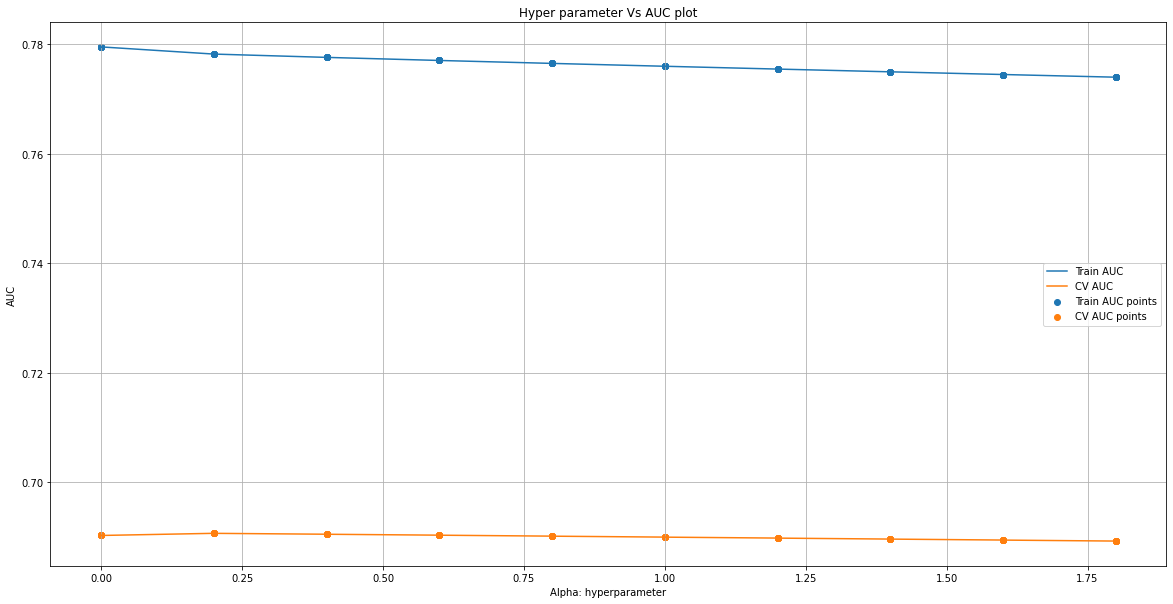

In [39]:
plot_hyper_auc(results)

In [40]:
print("Using grid serach we found that alpha is maximum at ",nb_gs_result.best_params_['alpha'])

Using grid serach we found that alpha is maximum at  0.20001000000000002


In [41]:
best_alpha_bow = nb_gs_result.best_params_['alpha']

In [42]:
best_prior_flag = nb_gs_result.best_params_['fit_prior']

In [43]:
best_prior_vals = nb_gs_result.best_params_['class_prior']

In [44]:
multi_nb_best = MultinomialNB(alpha=best_alpha_bow,class_prior=best_prior_vals,fit_prior=best_prior_flag)
multi_nb_best.fit(X_train_set_1, y_train)

y_train_pred = batch_predict(multi_nb_best, X_train_set_1)    
y_test_pred = batch_predict(multi_nb_best, X_test_set_1)

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

In [45]:
roc_auc_bow_test = auc(test_fpr, test_tpr)

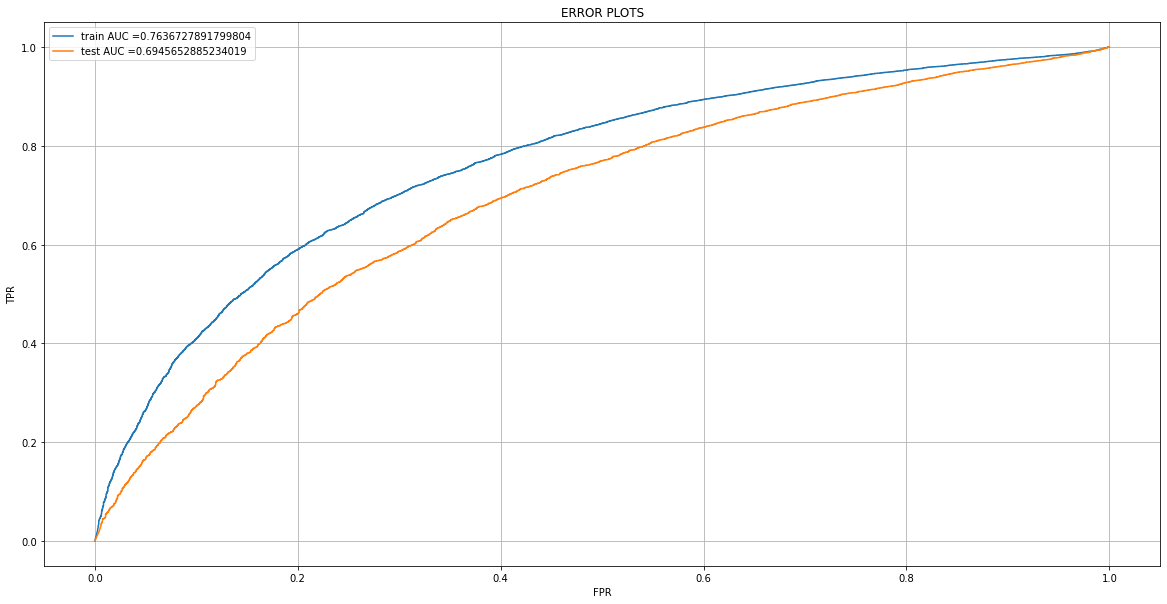

In [46]:
plt.figure(figsize=(20,10))
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ERROR PLOTS")
plt.grid()
plt.show()

In [47]:
# we are writing our own function for predict, with defined thresould
# we will pick a threshold that will give the least fpr
def find_best_threshold(threshould, fpr, tpr):
    t = threshould[np.argmax(tpr*(1-fpr))]
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    return t

def predict_with_best_t(proba, threshould):
    predictions = []
    for i in proba:
        if i>=threshould:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

In [48]:
print("="*100)
best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)

the maximum value of tpr*(1-fpr) 0.4931075126896996 for threshold 0.835


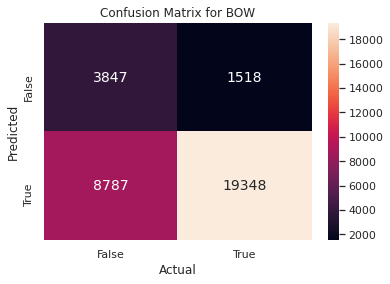

In [49]:
confusion_matrix_train = confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t))
sns.set(font_scale=1);
ax = sns.heatmap(confusion_matrix_train, annot=True,annot_kws={"size": 14},fmt='g');
ax.set_xlabel('Actual');
ax.set_ylabel('Predicted');
ax.set_title('Confusion Matrix for BOW');
ax.xaxis.set_ticklabels(['False','True']);
ax.yaxis.set_ticklabels(['False','True']);

In [50]:
print("Test confusion matrix")
confusion_matrix_test = confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t))

Test confusion matrix


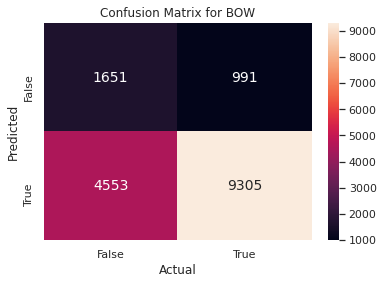

In [51]:
sns.set(font_scale=1);
ax = sns.heatmap(confusion_matrix_test, annot=True,annot_kws={"size": 14},fmt='g');
ax.set_xlabel('Actual');
ax.set_ylabel('Predicted');
ax.set_title('Confusion Matrix for BOW');
ax.xaxis.set_ticklabels(['False','True']);
ax.yaxis.set_ticklabels(['False','True']);

In [52]:
#print('Accuracy Score: ',accuracy_score(y_test, predict_with_best_t(y_test_pred, best_t)))

### TFIDF

Reusing the previous grid params

In [53]:
print(grid_parms)

{'alpha': [1e-05, 0.20001000000000002, 0.40001000000000003, 0.60001, 0.8000100000000001, 1.00001, 1.20001, 1.40001, 1.60001, 1.8000099999999999], 'class_prior': [(0.25, 0.75), (0.5, 0.5), (0.75, 0.25)], 'fit_prior': ['True', 'False']}


In [54]:
multi_nb_tfidf_gs = GridSearchCV(MultinomialNB(),grid_parms,verbose=True,scoring='roc_auc',return_train_score=True)
nb_tfidf_gs_result = multi_nb_tfidf_gs.fit(X_train_set_2,y_train)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:   21.8s finished


In [55]:
print("Best Score and params: %f using %s" % (nb_tfidf_gs_result.best_score_,nb_tfidf_gs_result.best_params_))

Best Score and params: 0.659561 using {'alpha': 1e-05, 'class_prior': (0.25, 0.75), 'fit_prior': 'True'}


In [56]:
results = pd.DataFrame.from_dict(multi_nb_tfidf_gs.cv_results_)

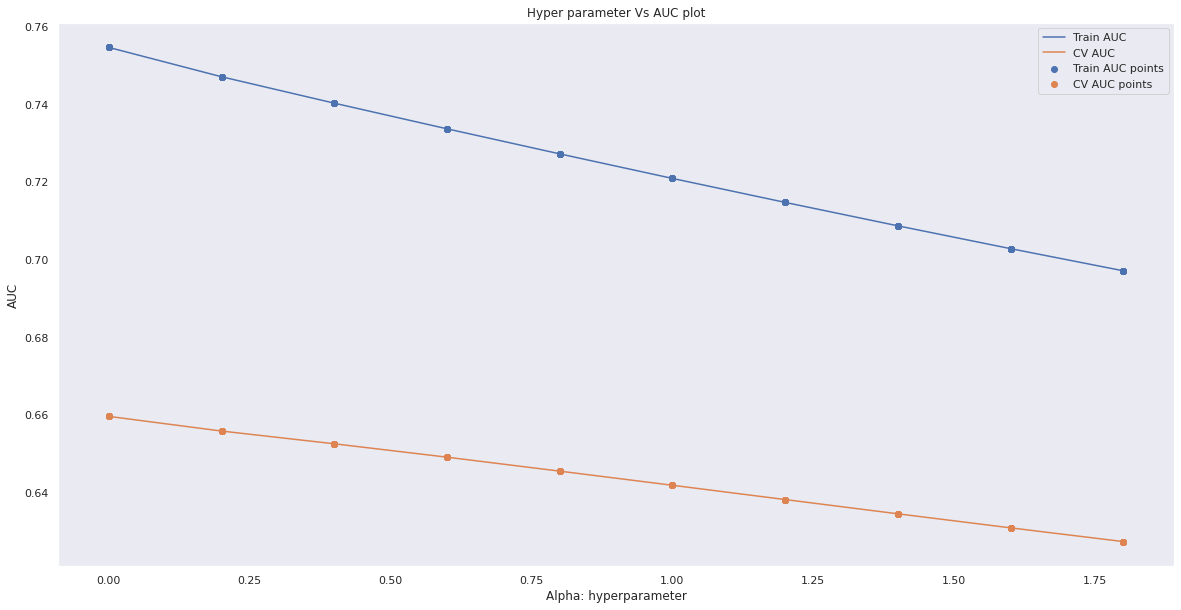

In [57]:
plot_hyper_auc(results)

In [58]:
print("Using grid serach we found that alpha is maimum at ",nb_tfidf_gs_result.best_params_['alpha'])

Using grid serach we found that alpha is maimum at  1e-05


In [59]:
best_alpha_tfidf = nb_tfidf_gs_result.best_params_['alpha']

In [60]:
best_prior_flag = nb_tfidf_gs_result.best_params_['fit_prior']

In [61]:
best_prior_vals = nb_tfidf_gs_result.best_params_['class_prior']

In [62]:
multi_nb_tfidf_best = MultinomialNB(alpha=best_alpha_tfidf,class_prior=best_prior_vals,fit_prior=best_prior_flag)
multi_nb_tfidf_best.fit(X_train_set_2, y_train)

y_train_pred = batch_predict(multi_nb_tfidf_best, X_train_set_2)    
y_test_pred = batch_predict(multi_nb_tfidf_best, X_test_set_2)

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

In [63]:
roc_auc_tfidf_test = auc(test_fpr, test_tpr)

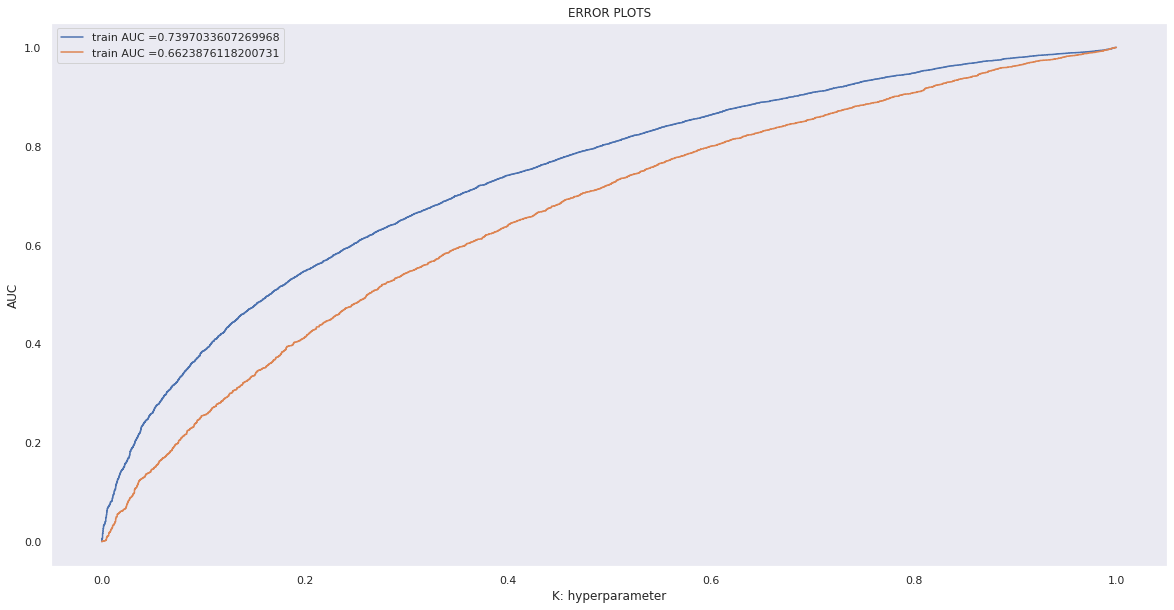

In [64]:
plt.figure(figsize=(20,10))
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="train AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.grid()
plt.show()

In [65]:
print("="*100)
best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)

print("Train confusion matrix")
confusion_matrix_train = confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t))

the maximum value of tpr*(1-fpr) 0.45915455885955264 for threshold 0.763
Train confusion matrix


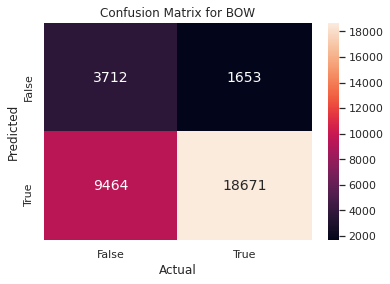

In [66]:
sns.set(font_scale=1);
ax = sns.heatmap(confusion_matrix_train, annot=True,annot_kws={"size": 14},fmt='g');
ax.set_xlabel('Actual');
ax.set_ylabel('Predicted');
ax.set_title('Confusion Matrix for BOW');
ax.xaxis.set_ticklabels(['False','True']);
ax.yaxis.set_ticklabels(['False','True']);

In [67]:
print("Test confusion matrix")
confusion_matrix_test = confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t))

Test confusion matrix


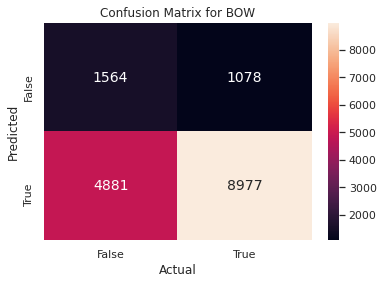

In [68]:
sns.set(font_scale=1);
ax = sns.heatmap(confusion_matrix_test, annot=True,annot_kws={"size": 14},fmt='g');
ax.set_xlabel('Actual');
ax.set_ylabel('Predicted');
ax.set_title('Confusion Matrix for BOW');
ax.xaxis.set_ticklabels(['False','True']);
ax.yaxis.set_ticklabels(['False','True']);

### Feature importance BOW

In [69]:
feature_importance_bow = feature_importance_list
feature_importance_bow.extend(essay_bow_feature_names)

In [70]:
pos_index=multi_nb_best.feature_log_prob_[1, :].argsort()
pos_features=np.take(feature_importance_bow,pos_index[-20:])
print("Important features : \n")
print(pos_features)

Important features : 

['able' 'day' 'use' 'need' 'we' 'reading' 'work' 'nannan' 'many' 'help'
 'my students' 'learn' 'they' 'not' 'the' 'classroom' 'learning' 'my'
 'school' 'students']


### Feature importance TFIDF

In [71]:
feature_importance_list_tfidf = feature_importance_list
feature_importance_list_tfidf.extend(essay_tfidf_feature_names)

In [72]:
pos_index=multi_nb_tfidf_best.feature_log_prob_[1, :].argsort()
pos_features=np.take(feature_importance_list_tfidf,pos_index[-20:])
print("Important features : \n")
print(pos_features)

Important features : 

['mr' 'grades_9_12' 'appliedlearning' 'students' 'specialneeds'
 'specialneeds' 'literacy_language math_science' 'health_wellness' 'ca'
 'grades_6_8' 'health_sports' 'literature_writing' 'mathematics'
 'literacy' 'grades_3_5' 'ms' 'math_science' 'grades_prek_2'
 'literacy_language' 'mrs']


In [73]:
#http://zetcode.com/python/prettytable/
from prettytable import PrettyTable
x = PrettyTable()

x.field_names = ["Vectorizor", "Model","Hyper Parameter","Test AUC"]
x.add_row(["BOW using Multinominal NB","Brute",best_alpha_bow,roc_auc_bow_test])
x.add_row(["TF-IDF using Multinominal NB","Brute",best_alpha_tfidf,roc_auc_tfidf_test])

print(x)

+------------------------------+-------+---------------------+--------------------+
|          Vectorizor          | Model |   Hyper Parameter   |      Test AUC      |
+------------------------------+-------+---------------------+--------------------+
|  BOW using Multinominal NB   | Brute | 0.20001000000000002 | 0.6945652885234019 |
| TF-IDF using Multinominal NB | Brute |        1e-05        | 0.6623876118200731 |
+------------------------------+-------+---------------------+--------------------+
